# NICE with MNIST

* `NICE: Non-Linear Independent Components Estimation`, [arXiv:1410.8516](https://arxiv.org/abs/1410.8516)
  * Laurent Dinh, David Krueger and Yoshua Bengio
  
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and [`eager execution`](https://www.tensorflow.org/guide/eager).

## 1. Import modules

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
tf.autograph.set_verbosity(0)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
# Training Flags (hyperparameter configuration)
model_name = 'nice'
train_dir = os.path.join('train', model_name, 'exp1')

max_epochs = 1500
save_model_epochs = 100
print_steps = 50
save_images_epochs = 50
batch_size = 256
learning_rate = 1e-4
num_examples_to_generate = 10
MNIST_SIZE = 28
noise_dim = MNIST_SIZE**2

## 2. Load the MNIST dataset

In [ ]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data.reshape(-1, MNIST_SIZE**2).astype('float32')
train_data = train_data / 255.

## 3. Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [ ]:
def _add_uniform_noise(image):
  noise = tf.random.uniform(image.get_shape(), maxval=1./255)
  return tf.clip_by_value(image + noise, 0., 1.)

In [ ]:
#tf.random.set_seed(219)

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.map(_add_uniform_noise)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: (256, 784), types: tf.float32>


## 4. Create the NICE models

In [ ]:
class ReLUMLP(tf.keras.Model):
  def __init__(self, input_size):
    super(ReLUMLP, self).__init__()
    self.input_size = input_size
    self.fc1 = layers.Dense(units=1000, activation='relu')
    self.fc2 = layers.Dense(units=1000, activation='relu')
    self.fc3 = layers.Dense(units=1000, activation='relu')
    self.fc4 = layers.Dense(units=MNIST_SIZE**2-self.input_size)

  def call(self, inputs, training=True):
    """Run the model."""
    fc1 = self.fc1(inputs)
    fc2 = self.fc2(fc1)
    fc3 = self.fc3(fc2)
    fc4 = self.fc4(fc3)
    
    return fc4

In [ ]:
def partition(inputs, method='oddeven', p1_size=MNIST_SIZE**2//2):
  if method == 'oddeven':
    partition1 = inputs[:, 0::2]
    partition2 = inputs[:, 1::2]
  elif method == 'topdown':
    partition1 = inputs[:, :p1_size]
    partition2 = inputs[:, p1_size:]
  else:
    raise ValueError('Not allowed method')
    
  return partition1, partition2

In [ ]:
def merge(partition1, partition2, method='oddeven'):
  if method == 'oddeven':
    merged = []
    for j in range(partition1.shape[1]):
      merged.append(partition1[:,j])
      merged.append(partition2[:,j])
    merged = tf.stack(merged, axis=1)
  elif method == 'topdown':
    merged = tf.concat((partition1, partition2), axis=1)
  else:
    raise ValueError('Not allowed method')

  return merged

In [ ]:
class AdditiveCouplingLayer(tf.keras.Model):
  def __init__(self, partition_method, input_size):
    super(AdditiveCouplingLayer, self).__init__()
    self.partition_method = partition_method
    self.input_size = input_size
    self.relumlp = ReLUMLP(self.input_size)
    
    # (random) permutation index
    indices = np.asarray(range(MNIST_SIZE**2), dtype=np.int32)
    indices = np.random.permutation(indices)
    
    # Reverse it
    indices_inverse = np.zeros(shape=indices.shape, dtype=np.int32)
    for i in range(MNIST_SIZE**2):
      indices_inverse[indices[i]] = i
    
    # convert to tensor
    self.tf_indices = tf.Variable(indices, name='tf_indices', dtype=tf.int32)
    self.tf_indices_inverse = tf.Variable(indices_inverse, name='tf_indices_inverse', dtype=tf.int32)
    
  def call(self, x):
    # permutation x
    x = tf.gather(x, self.tf_indices, axis=1)
    x1, x2 = partition(x, self.partition_method)
    y1 = x1
    y2 = x2 + self.relumlp(x1)
    
    return merge(y1, y2, self.partition_method)
    
  def inverse(self, y):
    y1, y2 = partition(y, self.partition_method)
    x1 = y1
    x2 = y2 - self.relumlp(y1)
    x = merge(x1, x2, self.partition_method)
    # inverse permutation x
    x = tf.gather(x, self.tf_indices_inverse, axis=1)
    
    return x

In [ ]:
class NICE(tf.keras.Model):
  def __init__(self, partition_method, partition_size):
    super(NICE, self).__init__()
    self.global_step = tf.Variable(0, trainable=False)
    self.partition_method = partition_method
    self.partition_size1 = partition_size
    self.partition_size2 = MNIST_SIZE**2 - partition_size
    
    self.coupling1 = AdditiveCouplingLayer(self.partition_method, self.partition_size1)
    self.coupling2 = AdditiveCouplingLayer(self.partition_method, self.partition_size2)
    self.coupling3 = AdditiveCouplingLayer(self.partition_method, self.partition_size1)
    self.coupling4 = AdditiveCouplingLayer(self.partition_method, self.partition_size2)
    self.log_scaling = tf.Variable(np.zeros([MNIST_SIZE**2]), trainable=True, name='log_scaling', dtype=tf.float32)
    
  def call(self, inputs):
    h1 = self.coupling1(inputs)
    h2 = self.coupling2(h1)
    h3 = self.coupling3(h2)
    h4 = self.coupling4(h3)
    h = h4 * tf.exp(self.log_scaling)
    
    return h, self.log_scaling
  
  def generate_sample(self, noise_vector):
    h4 = noise_vector / tf.exp(self.log_scaling)
    h3 = self.coupling4.inverse(h4)
    h2 = self.coupling3.inverse(h3)
    h1 = self.coupling2.inverse(h2)
    x = self.coupling1.inverse(h1)
    
    return x

In [ ]:
nice = NICE(partition_method='oddeven', partition_size=MNIST_SIZE**2//2)

## 5. Define the loss functions and the optimizer

In [ ]:
def negative_log_likelihood(h, prior='gaussian'):
  if prior == 'logistic':
    log_likelihood = -tf.reduce_sum( tf.math.softplus(h) + tf.math.softplus(-h), axis=1 )
  elif prior == 'gaussian':
    log_likelihood = -0.5 * tf.reduce_sum(h**2, axis=1)

  return -tf.reduce_mean(log_likelihood, axis=0)

### Define optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

### 6. Training

In [ ]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the nice.
location = 0.0 # location
scale = 0.5 # scale
random_vector_for_generation = tf.random.normal([num_examples_to_generate, noise_dim], mean=location, stddev=scale)

### Define training one step function

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  with tf.GradientTape() as tape:
    hidden_state, log_scaling = nice(images)
    nll = negative_log_likelihood(hidden_state, prior='logistic')
    ss = -tf.reduce_sum(log_scaling) # sum of log scaling
    loss = nll + ss

  gradients = tape.gradient(loss, nice.variables)
  optimizer.apply_gradients(zip(gradients, nice.trainable_variables))

  return loss, nll, ss, hidden_state

(10, 784)
(10, 28, 28)


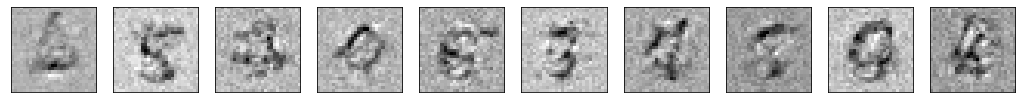

KeyboardInterrupt: ignored

In [ ]:
print('Start Training.')


for epoch in range(max_epochs):
  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    loss, nll, ss, hidden_state = train_step(images)
    nice.global_step.assign_add(1)
    global_step = nice.global_step.numpy()
    
    if global_step % 100 == 0:
        print('global step :', global_step, 'negative log-likelihood :', nll)

    if global_step % 200 == 0:
        display.clear_output(wait=True)
        sample_images = nice.generate_sample(random_vector_for_generation)
        sample_images = tf.reshape(sample_images, (num_examples_to_generate, MNIST_SIZE, MNIST_SIZE))
        plt.figure(figsize=[18, 3])
        for j in range(num_examples_to_generate):
            plt.subplot(1, num_examples_to_generate, j+1)
            plt.imshow(sample_images[j], cmap='binary')
            plt.xticks([])
            plt.yticks([])
        plt.show()     
